In this code example, we'll create a spline in 1D. In later examples, we'll create splines in 2D and 3D, and use them to control a quadrotor. But for now, we'll keep it simple and use flashlight to create a 1D spline.

Note that we need to explicitly add the lib folder that contains flashlight to Python's system path for the duration of the Python session. This strategy enables us to import flashlight without needing to copy it into the Python distribution's site-packages folder. Modifying the Python system path in this way is not persistent. This installation-free design is intended to make flashlight easier to use in projects where developers don't have acces to the underlying Python distribution (e.g., on compute clusters, or on servers that undergraduates use).

In [1]:
%pylab inline
from pylab import *

import path_utils
path_utils.add_relative_to_current_source_file_path_to_sys_path("../../lib")

import flashlight.gradient_utils as gradient_utils
import flashlight.spline_utils   as spline_utils

Populating the interactive namespace from numpy and matplotlib
Initializing flashlight v0.0.1


Next, we need to specify the value of our 1D spline function at a few places. We will informally refer to the places where we specify the value of our function as _keyframes_. Then, we will compute a spline function that smoothly interpolates the keyframes we specify. In this example, `t` is the independent function parameter, and `p` is the value of the function. We specify an array of `t` values, and a corresponding array of `p` values. Note that the two arrays must have the same shape, and should each have one column for each spatial dimension. In this example, our keyframes are 1D, so our arrays of `t` and `p` values each have a single column.

In [2]:
T = matrix([0,1,4,5]).T.A
P = matrix([0,9,1,4]).T.A

print "T = "; print T; print; print "P = "; print P

T = 
[[0]
 [1]
 [4]
 [5]]

P = 
[[0]
 [9]
 [1]
 [4]]


In addition to specifying keyframes, we also specify the degree of spline we want. In this example, we want `degree=7`. flashlight supports `degree=5,7,9`.

We also specify what derivative (or mixture of derivatives) we want to minimize across our spline. We do this by specifying a `lamb` array. `lamb=[1,0,0,0,0]` would minimize the square of the 1st derivative across the spline, `lamb=[0,1,0,0,0]` would minimize the square of the 2nd derivative across the spline, and so on. The `lamb` array can also be used to specify tradeoffs between minimizing different derivaties. For example, `lamb=[0.5,0.5,0.0,0.0,0.0]` would trade off evenly between minimizing the square of the 1st and 2nd derivatives evenly.

In our experience, minimizing the square of the 4th derivative (the 4th derivative is also known as the snap) of a 7th degree polynomial yields the smoothest and most reasonably bounded control signals for quadrotors. For more details on the underlying optimization problem being solved here, see [1].

By default, the spline returned by `spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients` will be C4 continuous.

`spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients` returns several objects that are used by flashlight internally to evaluate the spline. Understanding what these objects are isn't required to use flashlight correctly, but in case you're curious, `C` is an array that contains the polynomial coefficients for each segment of the spline in a normalized 0-to-1 parameter space. By default, `C` also contains the derivative values of the spline segments at the keyframe values, also in the normalized 0-to-1 parameter space, since these derivatives are solved for jointly with the polynomial coefficients.

#### References

[1] Niels Joubert, Mike Roberts, Anh Truong, Floraine Berthouzoz, Pat Hanrahan. An Interactive Tool for Designing Quadrotor Camera Shots. _ACM Transactions on Graphics 34(6) (SIGGRAPH Asia 2015)_.

In [3]:
C, T, sd = \
    spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients(
        P, T, degree=7, lamb=[0,0,0,1,0])

We solve for the polynomial coefficients in a normalized parameter space for numerical stability. But doing so makes evaluating the spline less straightforward. We provide the convenience function `spline_utils.evaluate_minimum_variation_nonlocal_interpolating_b_spline` for evaluating the splines computed with flashlight. `P_eval` contains the evaluated _p_ values. `T_eval` contains the evaluated `t` values.

In [4]:
P_eval, T_eval, dT = \
    spline_utils.evaluate_minimum_variation_nonlocal_interpolating_b_spline(
        C, T, sd, num_samples=500)

t = T_eval[:,0]

At this point, we're ready to plot the spline. We see that our spline function does indeed interpolate our keyframes.

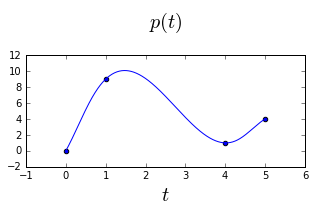

In [5]:
figsize(5,2);
plot(t, P_eval[:,0]); scatter(T[:,0], P[:,0]);
title("$p(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

We can also verify that our spline is C4 continuous by plotting its derivatives. Note that we use `gradient_utils.gradients_scalar_wrt_scalar_smooth_boundaries` to compute the derivatives of our function. Our function is conceptually similar to `numpy.gradient`, except ours includes some extra logic to avoid numerical artifacts at the boundaries. This extra logic protects us from the pronounced boundary artifacts that can occur when computing high-order derivatives using finite differences. We see on these plots that our spline is indeed continuous up to the 4th derivative.

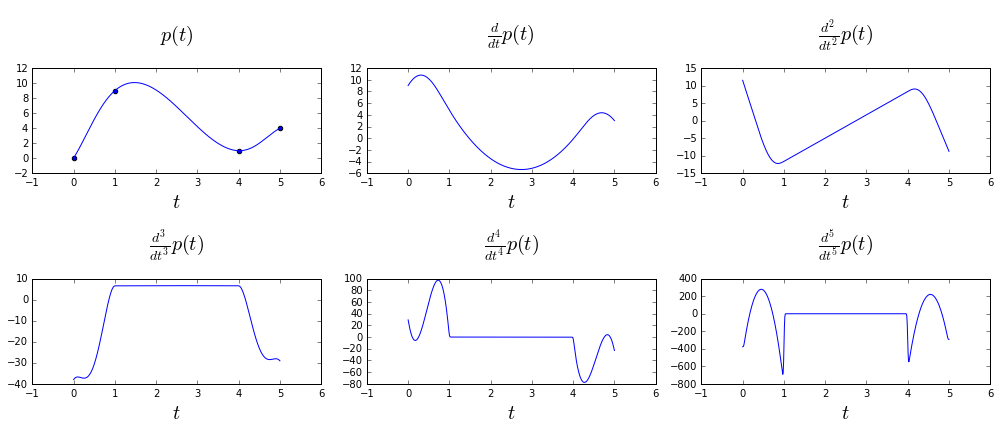

In [6]:
dpdtN = gradient_utils.gradients_scalar_wrt_scalar_smooth_boundaries(
    P_eval[:,0], dT[0], max_gradient=5, poly_deg=5)

figsize(14,6)

subplot(231); plot(t, dpdtN[0,:]); scatter(T[:,0], P[:,0]); xlims=xlim();
title("$p(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

subplot(232); plot(t, dpdtN[1,:]); xlim(xlims);
title("$\\frac{d}{dt}p(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

subplot(233); plot(t, dpdtN[2,:]); xlim(xlims);
title("$\\frac{d^2}{dt^2}p(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

subplot(234); plot(t, dpdtN[3,:]); xlim(xlims);
title("$\\frac{d^3}{dt^3}p(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

subplot(235); plot(t, dpdtN[4,:]); xlim(xlims);
title("$\\frac{d^4}{dt^4}p(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

subplot(236); plot(t, dpdtN[5,:]); xlim(xlims);
title("$\\frac{d^5}{dt^5}p(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

gcf().tight_layout();